# PFN with global features

## Read Input X with cell level features

In [1]:
import uproot as ur
import awkward as ak
import numpy as np

In [2]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

from energyflow.utils import data_split

In [4]:
# my worspace and directories
path_prefix = '/home/dportill/LCStudies/'
plotpath = path_prefix+'classifier/Plots_EFN/'
modelpath = path_prefix+'classifier/Models_EFN/'


data_path = '/fast_scratch/atlas_images/v01-45/'

In [5]:
# import graph utilities
import sys
sys.path.append(path_prefix)
from  util import graph_util as gu
from  util import plot_util as pu

In [6]:
#X = np.load(data_path+'X_4.npy')
X = np.load(path_prefix+'X_added.npy')

In [7]:
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(90000), np.zeros(90000))))

## Add global Energy and EMProb

In [9]:
path_pipm = data_path + 'pipm_medium.root'
path_pi0  = data_path + 'pi0_medium.root'

In [10]:
tree_pipm = ur.open(path_pipm)['EventTree']
tree_pi0  = ur.open(path_pi0)['EventTree']

In [12]:
## Cluster branches
tree_pi0.keys("cluster_*")

['cluster_E',
 'cluster_E_LCCalib',
 'cluster_Pt',
 'cluster_Eta',
 'cluster_Phi',
 'cluster_nCells',
 'cluster_ENG_CALIB_TOT',
 'cluster_ENG_CALIB_OUT_T',
 'cluster_ENG_CALIB_DEAD_TOT',
 'cluster_EM_PROBABILITY',
 'cluster_HAD_WEIGHT',
 'cluster_OOC_WEIGHT',
 'cluster_DM_WEIGHT',
 'cluster_CENTER_MAG',
 'cluster_FIRST_ENG_DENS',
 'cluster_CENTER_LAMBDA',
 'cluster_ISOLATION',
 'cluster_ENERGY_DigiHSTruth',
 'cluster_cell_ID',
 'cluster_cell_E',
 'cluster_hitsTruthIndex',
 'cluster_hitsTruthE']

### Cluster level quantities 

* loadVectorBranchFlat(branchName, tree): 

 converts to numpy a flatten array for the desired branch (no event index). 

In [13]:
clus_eta_pipm = gu.loadVectorBranchFlat('cluster_Eta', tree_pipm)
clus_E_pipm = gu.loadVectorBranchFlat('cluster_E', tree_pipm)
clus_phi_pipm = gu.loadVectorBranchFlat('cluster_Phi', tree_pipm)
clus_EM_PROB_pipm = gu.loadVectorBranchFlat('cluster_EM_PROBABILITY', tree_pipm)

In [15]:
clus_eta_pi0 = gu.loadVectorBranchFlat('cluster_Eta', tree_pi0)
clus_E_pi0 = gu.loadVectorBranchFlat('cluster_E', tree_pi0)
clus_phi_pi0  = gu.loadVectorBranchFlat('cluster_Phi', tree_pi0)
clus_EM_PROB_pi0  = gu.loadVectorBranchFlat('cluster_EM_PROBABILITY', tree_pi0)

In [30]:
print( "total number of pi0 clusters:", len(clus_EM_PROB_pi0))
print( "total number of pipm clusters:", len(clus_EM_PROB_pipm))
print( "total number of clusters:", len(clus_EM_PROB_pi0)+len(clus_EM_PROB_pipm))

total number of pi0 clusters: 421481
total number of pipm clusters: 672281
total number of clusters: 1093762


* Filter Events  $|\eta|<0.7$  and E>0.5 GeV

In [17]:
#Central Clusters
eta_mask_pipm = abs(clus_eta_pipm) < 0.7
eta_mask_pi0  = abs(clus_eta_pi0) < 0.7

#High energy clusters
energy_mask_pipm = clus_E_pipm > 0.5
energy_mask_pi0 = clus_E_pi0 > 0.5

In [18]:
selection_pipm = eta_mask_pipm & energy_mask_pipm
selection_pi0 = eta_mask_pi0 & energy_mask_pi0

In [32]:
X_glob_E_pipm = clus_E_pipm[selection_pipm]
X_glob_E_pi0 = clus_E_pi0[selection_pi0]

X_glob_EM_PROB_pipm = clus_EM_PROB_pipm[selection_pipm]
X_glob_EM_PROB_pi0 = clus_EM_PROB_pi0[selection_pi0]

In [33]:
print( "SELECTED total number of pi0 clusters:", len(X_glob_EM_PROB_pi0))
print( "SELECTED total number of pipm clusters:", len(X_glob_EM_PROB_pipm))
print( "SELECTED total number of clusters:", len(X_glob_EM_PROB_pi0)+len(X_glob_EM_PROB_pipm))

SELECTED total number of pi0 clusters: 92413
SELECTED total number of pipm clusters: 122850
SELECTED total number of clusters: 215263


* Create global feature 

In [34]:
X_glob_EM_PROB = np.concatenate( (X_glob_EM_PROB_pipm[:90000], X_glob_EM_PROB_pi0[:90000]) )
X_glob_E       = np.concatenate( (X_glob_E_pipm[:90000], X_glob_E_pi0[:90000]) )

* The len should be the same

In [36]:
print("clusters in X_glob_EM_PROB", len(X_glob_EM_PROB))
print("clusters in X_glob_E", len(X_glob_E))
print("clusters in X", len(X))

clusters in X_glob_EM_PROB 180000
clusters in X_glob_E 180000
clusters in X 180000


## Train with global EMProb

## PFN with dimension 4 inputs: (log(E),eta,phi,samplerID)

In [44]:
# ignore cellSignificance, cellVolume information 
X_4D=X[:,:,:4]

In [45]:
X_4D.shape[-1]

4

* Split data in train, val, test

In [37]:
from energyflow.utils import data_split

In [38]:
#### With no global feature:

# do train/val/test split 
#(X_train, X_val, X_test,
# Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)

In [47]:
(X_train, X_val, X_test, 
 Y_train, Y_val, Y_test, 
 X_glob_train, X_glob_val, X_glob_test) = data_split(X_4D, Y, X_glob_EM_PROB, val=10000, test=40000)

In [48]:
print("Train sample: ", len(X_train))
print("Validation sample: ", len(X_val))
print("Test sample: ", len(X_test))

print("GLOBAL Train sample: ", len(X_glob_train))
print("GLOBAL Validation sample: ", len(X_glob_val))
print("GLOBAL Test sample: ", len(X_glob_test))

Train sample:  130000
Validation sample:  10000
Test sample:  40000
GLOBAL Train sample:  130000
GLOBAL Validation sample:  10000
GLOBAL Test sample:  40000


* NETWORK CONFIGURATION

In [41]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [49]:
#concatenate the Xs (needed for global features):
X_tr = [X_train, X_glob_train] 
X_vali = [X_val, X_glob_val]
X_te = [X_test, X_glob_test]

In [58]:
#make the model:
pfn_EMProb = PFN(input_dim=X_train.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, num_global_features =1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [60]:
# train model
history_EMProb = pfn_EMProb.fit(X_tr, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_vali, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 16s 60ms/step - loss: 0.9041 - acc: 0.7571 - val_loss: 0.6310 - val_acc: 0.6864
Epoch 2/100
260/260 [==============================] - 16s 61ms/step - loss: 0.5909 - acc: 0.7740 - val_loss: 0.4139 - val_acc: 0.8227
Epoch 3/100
260/260 [==============================] - 15s 57ms/step - loss: 0.5101 - acc: 0.7844 - val_loss: 0.4022 - val_acc: 0.8147
Epoch 4/100
260/260 [==============================] - 15s 56ms/step - loss: 0.4137 - acc: 0.8119 - val_loss: 0.3836 - val_acc: 0.8628
Epoch 5/100
260/260 [==============================] - 15s 58ms/step - loss: 0.3866 - acc: 0.8232 - val_loss: 0.3862 - val_acc: 0.8057
Epoch 6/100
260/260 [==============================] - 14s 56ms/step - loss: 0.3747 - acc: 0.8374 - val_loss: 0.3443 - val_acc: 0.8666
Epoch 7/100
260/260 [==============================] - 14s 55ms/step - loss: 0.4827 - acc: 0.8385 - val_loss: 2.8050 - val_acc: 0.7225
Epoch 8/100
260/260 [==============================] - 

In [62]:
pfn_EMProb.save(modelpath+'pfn_EMProb.h5')

In [63]:
# get area under the ROC curve
preds_EMProb = pfn_EMProb.predict(X_te, batch_size=1000)
auc_EMProb = roc_auc_score(Y_test[:,1], preds_EMProb[:,1])
print('AUC:', auc_EMProb)

AUC: 0.9779076324186918


In [65]:
### get ROC curve
pfn_fp_EMProb, pfn_tp_EMProb, threshs_EMProb = roc_curve(Y_test[:,1], preds_EMProb[:,1])
Rej_EMProb=1./pfn_fp_EMProb
highEff=pfn_tp_EMProb>0.95
pfn_tp_highEff_EMProb = pfn_tp_EMProb[highEff]
Rej_highEff_EMProb=Rej_EMProb[highEff]
print("High efficiency AUC:",auc(pfn_tp_highEff_EMProb,Rej_highEff_EMProb))
print("Rejection at 95% efficiency:", Rej_highEff_EMProb[0])

print("at efficiency:", pfn_tp_highEff_EMProb[0])
print("AUC:",auc(pfn_tp_EMProb,Rej_EMProb))

High efficiency AUC: 0.2260840556798819
Rejection at 95% efficiency: 7.9823859087269815
at efficiency: 0.9500498504486541
AUC: inf


<ipython-input-65-bcb3f130a62a>:3: RuntimeWarning: divide by zero encountered in true_divide
  Rej_EMProb=1./pfn_fp_EMProb


<ipython-input-67-a5684adc464f>:9: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_EMProb, 1./(pfn_fp_EMProb), '-', color='red', label='PFN')
<ipython-input-67-a5684adc464f>:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(-1, 1000)


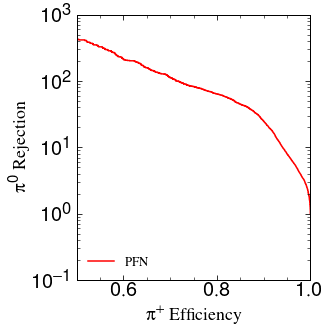

In [67]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

plt.yscale('log')

# plot the ROC curves
axes.plot(pfn_tp_EMProb, 1./(pfn_fp_EMProb), '-', color='red', label='PFN')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(-1, 1000)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.show()

In [68]:
pfn_4dim=tf.keras.models.load_model(modelpath+'pfn_4dim.h5')

In [71]:
# get area under the ROC curve
preds_4dim = pfn_4dim.predict(X_test, batch_size=1000)
auc_4dim = roc_auc_score(Y_test[:,1], preds_4dim[:,1])
print('AUC:', auc_4dim)


AUC: 0.9812221697495277


In [72]:
### get ROC curve
pfn_fp_4dim, pfn_tp_4dim, threshs_4dim = roc_curve(Y_test[:,1], preds_4dim[:,1])
Rej_4dim=1./pfn_fp_4dim
highEff=pfn_tp_4dim>0.95
pfn_tp_highEff_4dim = pfn_tp_4dim[highEff]
Rej_highEff_4dim=Rej_4dim[highEff]
print("High efficiency AUC:",auc(pfn_tp_highEff_4dim,Rej_highEff_4dim))
print("Rejection at 95% efficiency:", Rej_highEff_4dim[0])

print("at efficiency:", pfn_tp_highEff_4dim[0])
print("AUC:",auc(pfn_tp_4dim,Rej_4dim))

High efficiency AUC: 0.25369759220712235
Rejection at 95% efficiency: 9.348335677449601
at efficiency: 0.9500498504486541
AUC: inf


<ipython-input-72-c80103d6af57>:3: RuntimeWarning: divide by zero encountered in true_divide
  Rej_4dim=1./pfn_fp_4dim


<ipython-input-75-dbb09d51a904>:11: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_4dim, 1./(pfn_fp_4dim), '-', color='blue', label='3D+samplerID')
<ipython-input-75-dbb09d51a904>:12: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_EMProb, 1./(pfn_fp_EMProb), '-', color='red', label='3D+samplerID+EMProb')
<ipython-input-75-dbb09d51a904>:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(-1, 1000)


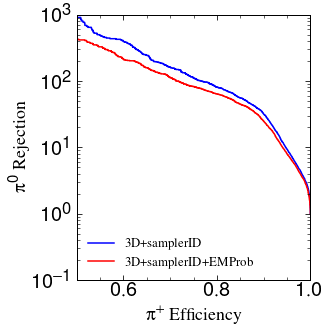

In [75]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

######################### ROC Curve Plot #########################

plt.yscale('log')


axes.plot(pfn_tp_4dim, 1./(pfn_fp_4dim), '-', color='blue', label='3D+samplerID')
axes.plot(pfn_tp_EMProb, 1./(pfn_fp_EMProb), '-', color='red', label='3D+samplerID+EMProb')
#axes.plot(pfn_tp_l200, 1./(pfn_fp_l200), '-', color='green', label='l=200')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(-1, 1000)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.savefig('/home/dportill/EMProb.pdf')

plt.show()